# Exercise 4: Regression and Classification

### By Jakub Tomkiewicz and Konrad Piotrowski

## Part 1. Data loading & analysis

In the beginning, we are loading the data into the program. The dataset we worked on contained two possible file types: txt and arff. We used arff because the file already included the column names. Moreover, arff file class 'column' consists of only two values (normal and anomaly), which is helpful later in the preprocessing part.

In [16]:
from scipy.io import arff
import pandas as pd

train_set = arff.loadarff('KDDTrain+.arff')[0]
test_set = arff.loadarff('KDDTest+.arff')[0]

train_set = pd.DataFrame(train_set)
test_set = pd.DataFrame(test_set)

print(f'train_set dimensions: {train_set.shape}')
print(f'test_set dimensions: {test_set.shape}')

train_set dimensions: (125973, 42)
test_set dimensions: (22544, 42)


As mentioned earlier, the 'class' column consists of only two options: normal and anomaly.

In [19]:
print('train_set class distribution:')
print(train_set['class'].value_counts())

print()

print('test_set class distribution:')
print(test_set['class'].value_counts())

train_set class distribution:
b'normal'     67343
b'anomaly'    58630
Name: class, dtype: int64

test_set class distribution:
b'anomaly'    12833
b'normal'      9711
Name: class, dtype: int64


## Part 2. Data preprocessing

From the heatmap, we can see that many columns have a high correlation value. To make the computing easier, we can remove the columns that have a close to 1 correlation value since they will not affect the result.

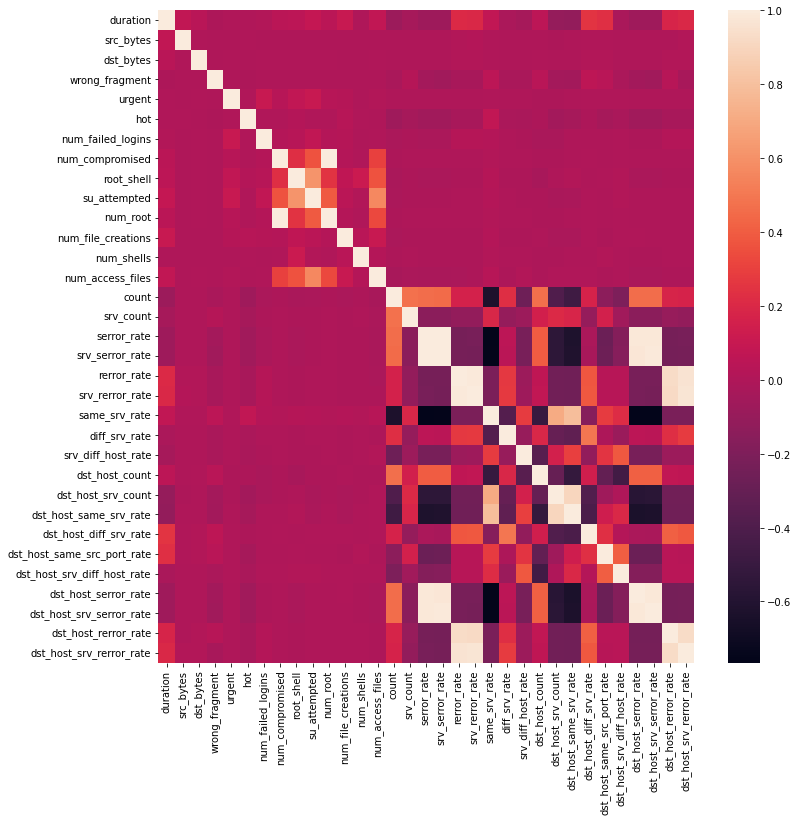

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns

train_set = train_set[[column for column in train_set if train_set[column].nunique() > 1]]

corr = train_set.corr()
plt.figure(figsize = (12, 12))
sns.heatmap(corr)
plt.show()

In [21]:
train_set = train_set.drop('num_root', axis = 1)
train_set = train_set.drop('srv_serror_rate', axis = 1)
train_set = train_set.drop('srv_rerror_rate', axis = 1)
train_set = train_set.drop('dst_host_srv_serror_rate', axis = 1)
train_set = train_set.drop('dst_host_serror_rate', axis = 1)
train_set = train_set.drop('dst_host_rerror_rate', axis = 1)
train_set = train_set.drop('dst_host_same_srv_rate', axis = 1)
train_set = train_set.drop('dst_host_srv_rerror_rate', axis = 1)

test_set = test_set.drop('num_root', axis = 1)
test_set = test_set.drop('srv_serror_rate', axis = 1)
test_set = test_set.drop('srv_rerror_rate', axis = 1)
test_set = test_set.drop('dst_host_srv_serror_rate', axis = 1)
test_set = test_set.drop('dst_host_serror_rate', axis = 1)
test_set = test_set.drop('dst_host_rerror_rate', axis = 1)
test_set = test_set.drop('dst_host_srv_rerror_rate', axis = 1)
test_set = test_set.drop('dst_host_same_srv_rate', axis = 1)

Since we need only numerical values in our dataset to perform the calculations, we must somehow change all strings into these numerical substitutes. We have created dictionaries with all unique strings for four columns (protocol_type, flag, service, class) and mapped the string values to integers.

In [22]:
protocol_types_dictionary = {}

types = test_set['protocol_type'].unique()
for x in range(len(types)):
    protocol_types_dictionary[types[x]] = x
test_set['protocol_type'] = test_set['protocol_type'].map(protocol_types_dictionary)
train_set['protocol_type'] = train_set['protocol_type'].map(protocol_types_dictionary)

flag_types_dictionary = {}

types = test_set['flag'].unique()
for x in range(len(types)):
    flag_types_dictionary[types[x]] = x
test_set['flag'] = test_set['flag'].map(flag_types_dictionary)
train_set['flag'] = train_set['flag'].map(flag_types_dictionary)

service_types_dictionary = {}

types = train_set['service'].unique()
for x in range(len(types)):
    service_types_dictionary[types[x]] = x
train_set['service'] = train_set['service'].map(service_types_dictionary)
test_set['service'] = test_set['service'].map(service_types_dictionary)

class_types_dictionary = {}

types = test_set['class'].unique()
for x in range(len(types)):
    class_types_dictionary[types[x]] = x
train_set['class'] = train_set['class'].map(class_types_dictionary)
test_set['class'] = test_set['class'].map(class_types_dictionary)

Since the number of columns in the train and test sets were different, we needed to check the difference in the collections of column names for both data sets. It turned out that the test set contained an additional row named num_outbound_cmds.

In [23]:
train_set_columns = train_set.columns
test_set_columns = test_set.columns

difference = test_set_columns.difference(train_set_columns)

print(difference)

Index(['num_outbound_cmds'], dtype='object')


In [24]:
test_set = test_set.drop('num_outbound_cmds', axis = 1)

As the Y values, we need to set the class columns since they contain the information on whether the packet is an anomaly or not. We can drop the class column when the Y is set and place all the remaining columns' data as the X value.

In [25]:
train_y = train_set['class']

train_set = train_set.drop('class', axis = 1)

train_x = train_set.iloc[:, :].values

test_y = test_set['class']

test_set = test_set.drop('class', axis = 1)

test_x = test_set.iloc[:, :].values

## Part 3. Prediction & evalutaion

Thanks to the pythons' sklearn (scikit-learn) library, the prediction and evaluation process is pretty straightforward. 

We used three different methods: Logistic Regression, Random Forest, and Decision Tree. 

In all of them, the implementation is nearly the same. We train the model using a suitable method that takes the input and output of the train data set as the parameters. After that, we can predict the test output value using predict method. The last step is to calculate the accuracy using the scoring method.

In [44]:
from sklearn.linear_model import LogisticRegression
import time

logistic_regression = LogisticRegression(max_iter=1000000)

start_time = time.time()

logistic_regression.fit(train_x, train_y)

lr_train_time = time.time() - start_time

print(f'training time: {lr_train_time}')

start_time = time.time()

logistic_regression.predict(test_x)

lr_test_time = time.time() - start_time

print(f'testing time: {lr_test_time}')

lr_score = logistic_regression.score(test_x, test_y)
print(f'accuracy: {lr_score}')

training time: 2.6025259494781494
testing time: 0.02452397346496582
accuracy: 0.7027146912704045


In [45]:
from sklearn.ensemble import RandomForestClassifier

random_forest = RandomForestClassifier()

start_time = time.time()

random_forest.fit(train_x, train_y)

rf_train_time = time.time() - start_time

print(f'training time: {rf_train_time}')

start_time = time.time()

random_forest.predict(test_x)

rf_test_time = time.time() - start_time

print(f'testing time: {rf_test_time}')

rf_score = random_forest.score(test_x, test_y)
print(f'accuracy: {rf_score}')

training time: 7.149439096450806
testing time: 0.20608997344970703
accuracy: 0.7776792051100071


In [46]:
from sklearn.tree import DecisionTreeClassifier

decision_tree = DecisionTreeClassifier(criterion="entropy")

start_time = time.time()

decision_tree.fit(train_x, train_y)

dt_train_time = time.time() - start_time

print(f'training time: {dt_train_time}')

start_time = time.time()

decision_tree.predict(test_x)

dt_test_time = time.time() - start_time

print(f'testing time: {dt_test_time}')

dt_score = decision_tree.score(test_x, test_y)
print(f'accuracy: {dt_score}')

training time: 0.585076093673706
testing time: 0.025918006896972656
accuracy: 0.7731547196593329


When comparing the accuracy of the three methods, the apparent differences are tiny. the best is Random Forest, but Logistic Regression and Decision Tree are only marginally worse.

<BarContainer object of 3 artists>

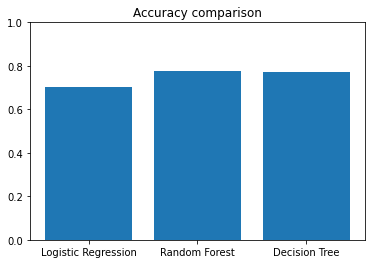

In [55]:
names = ['Logistic Regression', 'Random Forest', 'Decision Tree']

scores = [lr_score, rf_score, dt_score]

plt.figure()
plt.subplot()
plt.ylim([0, 1])
plt.title('Accuracy comparison')
plt.bar(names, scores)

Comparing training time gives the most spectacular differences. Decision Tree is by far the fastest, almost five times faster than Logistic Regression, not even comparable with Random Forest.

<BarContainer object of 3 artists>

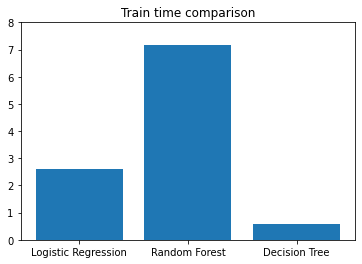

In [50]:
names = ['Logistic Regression', 'Random Forest', 'Decision Tree']

scores = [lr_train_time, rf_train_time, dt_train_time]

plt.figure()
plt.subplot()
plt.ylim([0, 8])
plt.title('Train time comparison')
plt.bar(names, scores)

When comparing the testing time, it's hard to find a favorite anymore. Logistic Regression and Decision Tree are practically equal and, therefore, much faster than Random Forest.

<BarContainer object of 3 artists>

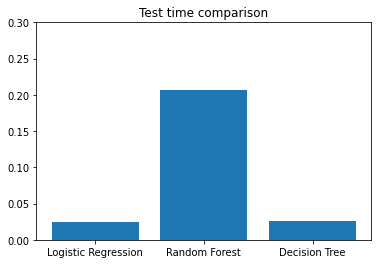

In [54]:
names = ['Logistic Regression', 'Random Forest', 'Decision Tree']

scores = [lr_test_time, rf_test_time, dt_test_time]

plt.figure()
plt.subplot()
plt.ylim([0, 0.3])
plt.title('Test time comparison')
plt.bar(names, scores)

Summing up the comparison of both times and accuracy, we can say that the Random Forest is the most accurate but the slowest. However, Decision Tree is by far the fastest, and its accuracy is only slightly inferior to that of the Random Forest.